In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [5]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        #创建的是一个action*rewart维度的数组
        Pi = np.zeros_like(Q[state])
        A_star = np.argmax(Q[state])
        Pi[A_star] = 1.0
        return Pi
    return policy_fn

In [6]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # C和Q是同类型的。
    C = defaultdict(lambda: np.zeros(env.action_space.n))
        
    for index in range(1, num_episodes+1):
        if index % 50000 == 0:
            print("the number is： %d\%d" %(index, num_episodes))
        
        episode = []
        state = env.reset()
        for t in range(10000):
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
            #break和转移的顺序，以前都没有注意，先break的话state是停在结束的前一个，而先state，则是结束时。
        G = 0
        W = 1
        for i in range(len(episode))[::-1]:
            state, action, reward = episode[i]
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W/C[state][action])*(G-Q[state][action])
            #下面两步可以直接替换：if action != np.argmax(target_policy(state)):
            #不用再次创建，在判断中调用的时候也就更新了策略。
            target_policy = create_greedy_policy(Q)
            if action != np.argmax(Q[state]):
                break
            W = W/behavior_policy(state)[action]
            
    return Q, target_policy

In [7]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

the number is： 50000\500000
the number is： 100000\500000
the number is： 150000\500000
the number is： 200000\500000
the number is： 250000\500000
the number is： 300000\500000
the number is： 350000\500000
the number is： 400000\500000
the number is： 450000\500000
the number is： 500000\500000


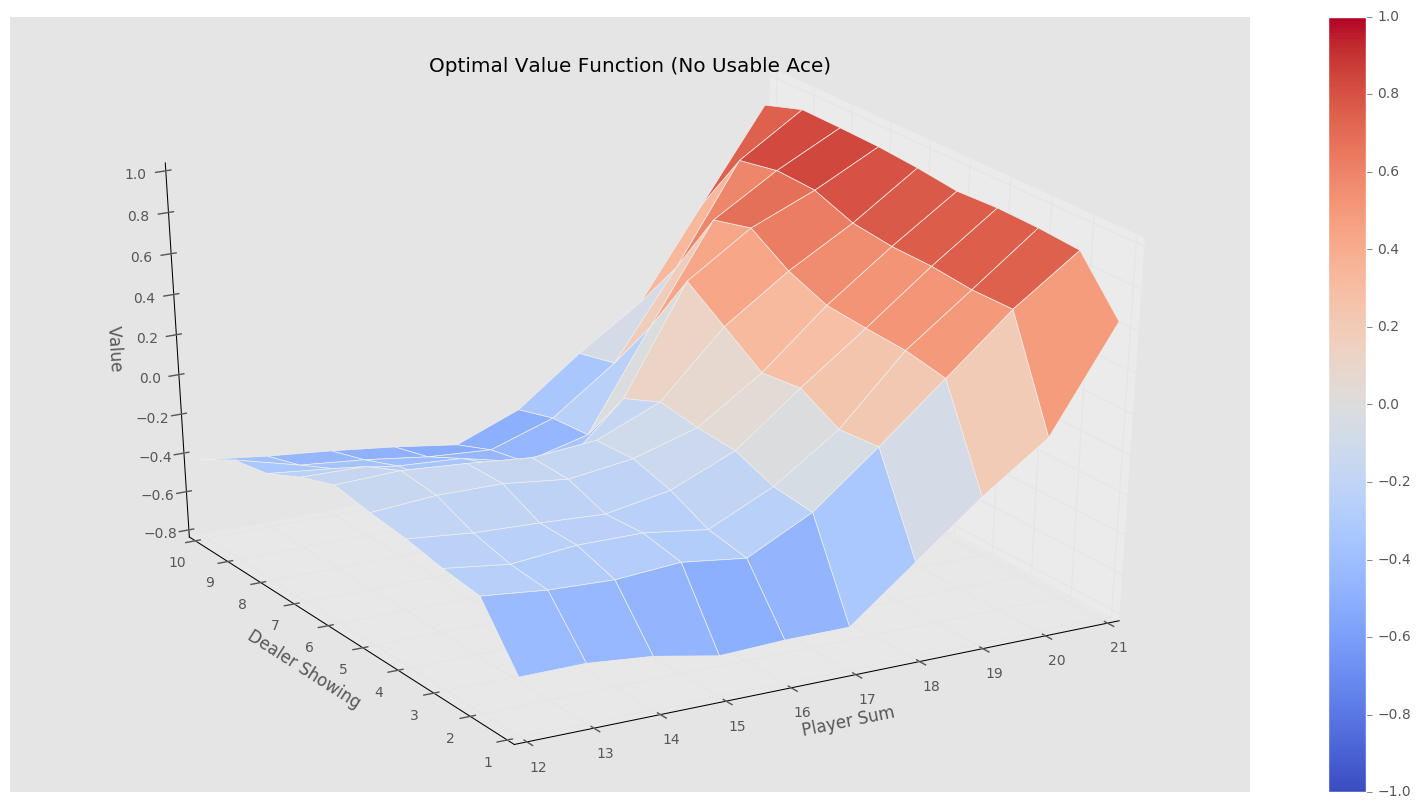

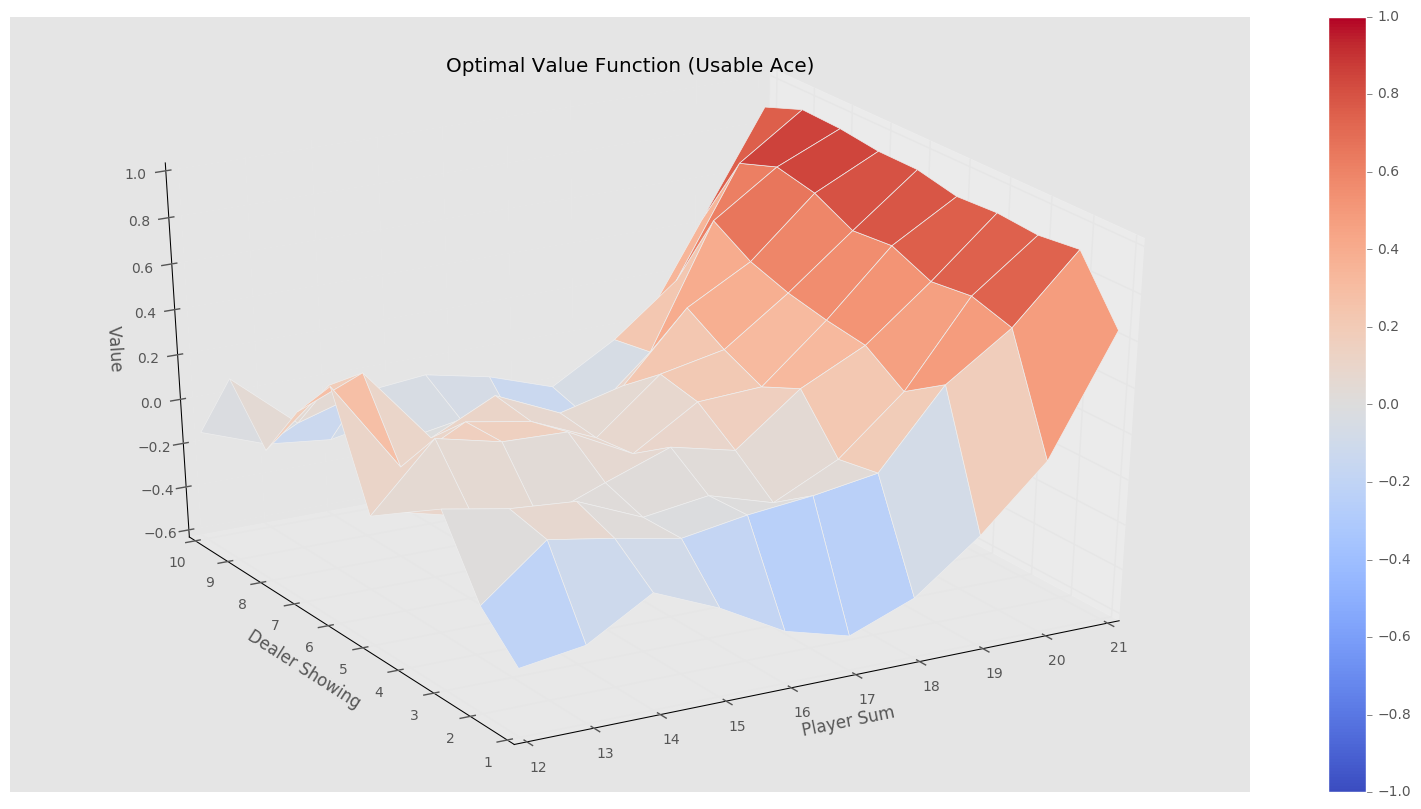

In [8]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")